### <span style="color:#3bbfa0; font-size:1.6em;">*How to Embed AI/ML Model in a Web App: Streamlit Tutorial Part 2*</span><br><span style="color:lightgray; font-size:1.2em;">*Super Image Resolution*</span>

<br>
    <img src="./assets/imgs/demo-app.gif" width="1000">
<br><br><br>

#### <span style="color:#3bbfa0; font-size:1.5em;">*Enhanced Super-Resolution Generative Adversarial Networks*</span>

<div style="height: 3px; background-color: #3bbfa0;"></div>
<br>
<img src="https://i.ibb.co/7VXbVLp/m2.png" width="400">

<div style="position: relative; width: 200px;">
    <img src="https://i.ibb.co/xhcsJ0d/duck-guy.png" style="position: absolute; bottom: 10px; right: 0px; width: 85px;">
</div>

<br>

### 1. Example Model
For this application we will use the [ESRGAN model](https://arxiv.org/pdf/1809.00219.pdf) (2018). ESRGAN stands for Enhanced Super-Resolution Generative Adversarial Networks. 

We're using the ESRGAN model for image enhancement. ESRGAN combines Super-Resolution techniques with Generative Adversarial Networks (GANs) to upscale images and add detail. In simple terms, ESRGAN acts like an art forger that turns small, blurry images into larger, clearer versions, while a critic (the discriminator) evaluates the quality. This model improves upon its predecessor, SRGAN, by generating more realistic and detailed images.

<img src="https://esrgan.readthedocs.io/en/latest/_images/architecture.png" width="600">


#### Key changes:

1. **Residual-in-Residual Dense Block (RRDB):**
The authors introduce a new network building unit called the Residual-in-Residual Dense Block (RRDB). This block is designed to be of higher capacity and easier to train compared to the residual blocks used in the original SRGAN. The RRDB does not include batch normalization layers, which is a departure from the original SRGAN architecture.

2. **Relativistic Discriminator:**
The paper incorporates the idea from Relativistic GANs to improve the discriminator. Instead of predicting the absolute realness of an image, the relativistic discriminator is trained to judge whether one image is more realistic than another. This approach helps the generator recover more realistic texture details.

3. **Improved Perceptual Loss:**
The authors propose an improved version of the perceptual loss by using the VGG features before activation, as opposed to after activation which was the case in SRGAN. This change provides stronger supervision for brightness consistency and texture recovery, resulting in sharper edges and more visually pleasing results.



<br><br><br>
### 2. ESRGAN model - AI Image Enhancer
___

In [2]:
!pip install tensorflow
!pip install --upgrade tensorflow-hub
!pip install Pillow

     ---------------------------------------- 0.0/100.6 kB ? eta -:--:--
     -------------------------------------- 100.6/100.6 kB 1.9 MB/s eta 0:00:00


In [1]:
import os
import time
import requests
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

The following code initiates the download of an image available online of a baboon, noted for its grainy quality. The file is saved as <font color="red">"original.png"</font>.

<img src="https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png" width="300">

In [2]:
url = "https://user-images.githubusercontent.com/12981474/40157448-eff91f06-5953-11e8-9a37-f6b5693fa03f.png"
response = requests.get(url)
with open('original.png', 'wb') as f:
    f.write(response.content)
    
# Declaring Constants
IMAGE_PATH = "original.png"
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [12]:
def load_and_preprocess_image(image_filepath):
    """
    Load and preprocess an image for the model.
    
    Args:
        image_filepath (str): Path to the image file.
        
    Returns:
        tf.Tensor: Preprocessed image.
    """
    # Load image and decode to tensor
    raw_image = tf.image.decode_image(tf.io.read_file(image_filepath))
    # Remove alpha channel if present
    if raw_image.shape[-1] == 4:
        raw_image = raw_image[..., :-1]
    # Ensure dimensions are multiples of 4
    image_size = (tf.convert_to_tensor(raw_image.shape[:-1]) // 4) * 4
    # Crop to new dimensions
    cropped_image = tf.image.crop_to_bounding_box(raw_image, 0, 0, image_size[0], image_size[1])
    # Convert to float32 type
    processed_image = tf.cast(cropped_image, tf.float32)
    # Add batch dimension
    return tf.expand_dims(processed_image, 0)

def save_processed_image(image_tensor, filename):
    """
    Save the processed image to a file.
    
    Args:
        image_tensor (tf.Tensor): Processed image.
        filename (str): Output filename.
    """
    # Clip values to be in the valid range [0, 255]
    image_tensor = tf.clip_by_value(image_tensor, 0, 255)
    # Convert tensor to PIL image
    output_image = Image.fromarray(tf.cast(image_tensor, tf.uint8).numpy())
    # Save image
    output_image.save(f"{filename}.jpg")
    print(f"Saved as {filename}.jpg")

def display_image(image_tensor, title=""):
    """
    Display an image in the notebook.
    
    Args:
        image_tensor (tf.Tensor): Image to display.
        title (str): Image title.
    """
    # Convert tensor to numpy array and clip values
    image_data = tf.clip_by_value(np.asarray(image_tensor), 0, 255)
    # Convert to PIL image for display
    displayed_image = Image.fromarray(tf.cast(image_data, tf.uint8).numpy())
    # Display the image
    plt.imshow(displayed_image)
    plt.axis("off")
    plt.title(title)

Saved as Original Image.jpg


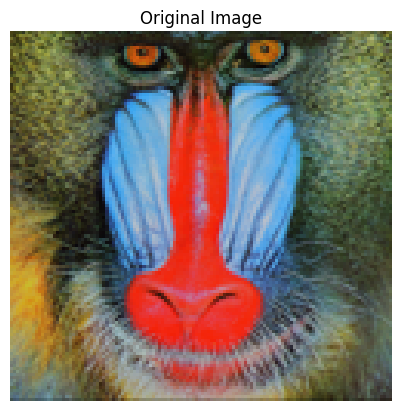

In [14]:
hr_image = load_and_preprocess_image(IMAGE_PATH)
# Plotting Original Resolution image
display_image(tf.squeeze(hr_image), title="Original Image")
save_processed_image(tf.squeeze(hr_image), filename="Original Image")

In [15]:
model = hub.load(SAVED_MODEL_PATH)

In [19]:
start = time.time()
upscaled_image = model(hr_image)
upscaled_image = tf.squeeze(upscaled_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 0.742104


Saved as Super Resolution.jpg


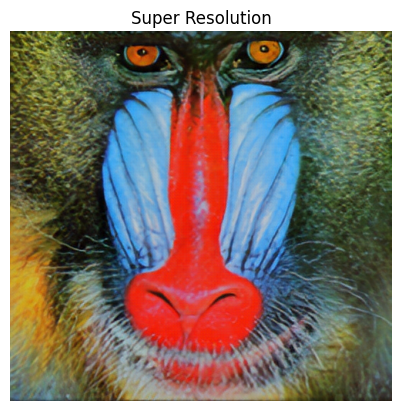

In [17]:
# Plotting Super Resolution Image
display_image(tf.squeeze(upscaled_image), title="Super Resolution")
save_processed_image(tf.squeeze(upscaled_image), filename="Super Resolution")

In [18]:
import tensorflow as tf

def load_and_preprocess_image(image_filepath):
    """
    Load and preprocess an image for the model.
    
    Args:
        image_filepath (str): Path to the image file.
        
    Returns:
        tf.Tensor: Preprocessed image.
    """
    # Load image and decode to tensor
    raw_image = tf.image.decode_image(tf.io.read_file(image_filepath))
    # Remove alpha channel if it exists
    if raw_image.shape[-1] == 4:
        raw_image = raw_image[..., :-1]
    # Ensure dimensions are multiples of 4
    image_size = (tf.convert_to_tensor(raw_image.shape[:-1]) // 4) * 4
    # Crop to new dimensions
    cropped_image = tf.image.crop_to_bounding_box(raw_image, 0, 0, image_size[0], image_size[1])
    # Convert to float32 data type
    processed_image = tf.cast(cropped_image, tf.float32)
    # Add batch dimension
    return tf.expand_dims(processed_image, 0)

<img src="./assets/imgs/demo-logo.gif">

<img src="https://i.ibb.co/xhcsJ0d/duck-guy.png" style="position: absolute; bottom: 10px; right: 0px; width: 85px;">